# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [6]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

### Задание 3

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].str.replace(',00 $ ','').str.replace(' ','').str.replace('0$', '0')
df['balance'] = df['balance'].astype('float')
print(f'Средний баланс: {round(df['balance'].mean(),3)}')

Средний баланс: 1529.129


### Задание 4

In [8]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код
df['balance'] = df['balance'].fillna(df['balance'].median())
print(f'Средний баланс: {round(df['balance'].mean(),3)}')

Средний баланс: 1526.936


### Задание 5

In [9]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
job_mode = df['job'].mode()[0]
education_mode = df['education'].mode()[0]
df['job'] = df['job'].replace('unknown', job_mode)
df['education'] = df['education'].replace('unknown', education_mode)
average_balance = df.loc[(df['job']==job_mode) & (df['education']== education_mode)]['balance'].mean()
print(f'Средний баланс клиентов с самой популярной работой и самым популярным образованием: {round(average_balance,3)}')

Средний баланс клиентов с самой популярной работой и самым популярным образованием: 1598.883


In [10]:
#df.groupby(['job', 'education'])['balance'].mean()
#df.pivot_table(values='balance', index='job', columns='education')

### Задание 6

Нижняя граница: -2241.0, верхняя граница: 4063.0
<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


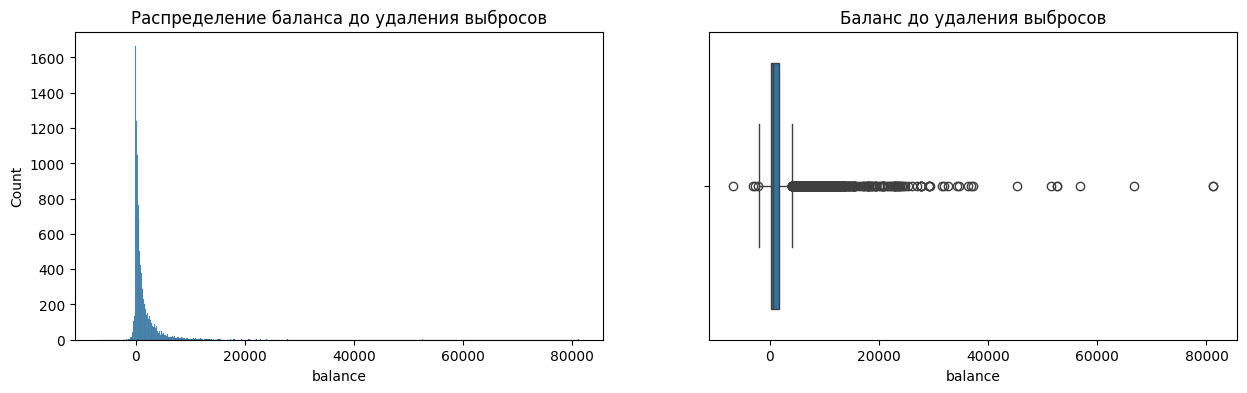

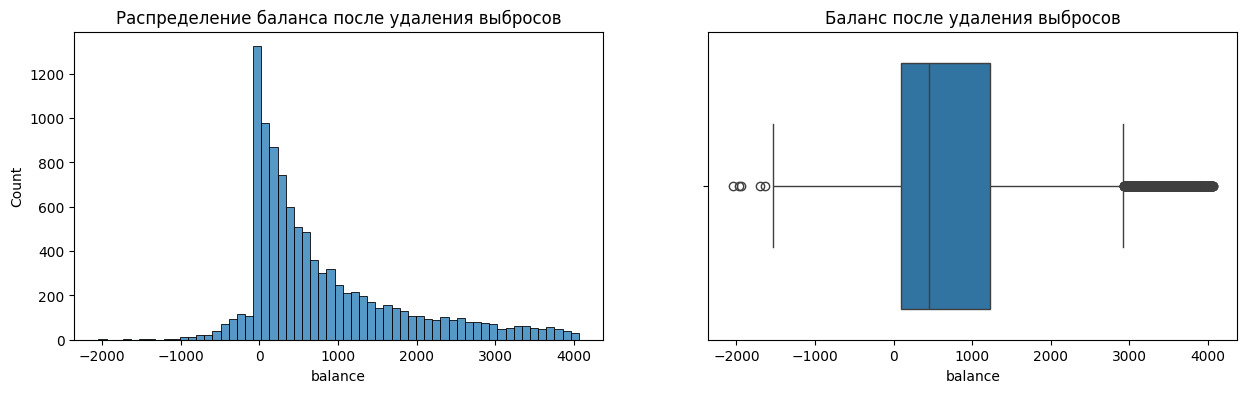

In [11]:
# удалите все выбросы для признака balance
# ваш код
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = df, x = 'balance', ax = axes[0]);
histplot.set_title('Распределение баланса до удаления выбросов')
boxplot = sns.boxplot( data = df, x = 'balance', ax = axes[1])
boxplot.set_title('Баланс до удаления выбросов')
lower_quart = np.percentile(df['balance'], 25)
upper_quart = np.percentile(df['balance'], 75)
#lower_quart = df['balance'].quantile(0.25)
#upper_quart = df['balance'].quantile(0.75)
iqr = upper_quart-lower_quart
lower_bound = lower_quart - (1.5*iqr)
upper_bound = upper_quart + (1.5*iqr)
print(f'Нижняя граница: {lower_bound}, верхняя граница: {upper_bound}')
df_filtered = df.copy()
df_filtered = df_filtered[(df_filtered['balance']>=lower_bound) & (df_filtered['balance']<=upper_bound)]
fig, axes = plt.subplots(1,2, figsize = (15,4))
histplot = sns.histplot(data = df_filtered, x = 'balance', ax = axes[0]);
histplot.set_title('Распределение баланса после удаления выбросов')
boxplot = sns.boxplot( data = df_filtered, x = 'balance', ax = axes[1])
boxplot.set_title('Баланс после удаления выбросов')
df_filtered.info()


## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: count, dtype: int64


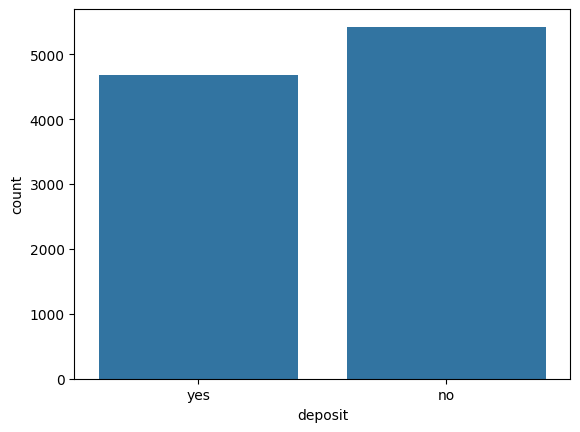

In [12]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
print(df_filtered['deposit'].value_counts())
sns.countplot(data=df_filtered, x='deposit');

### Задания 2 и 3

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


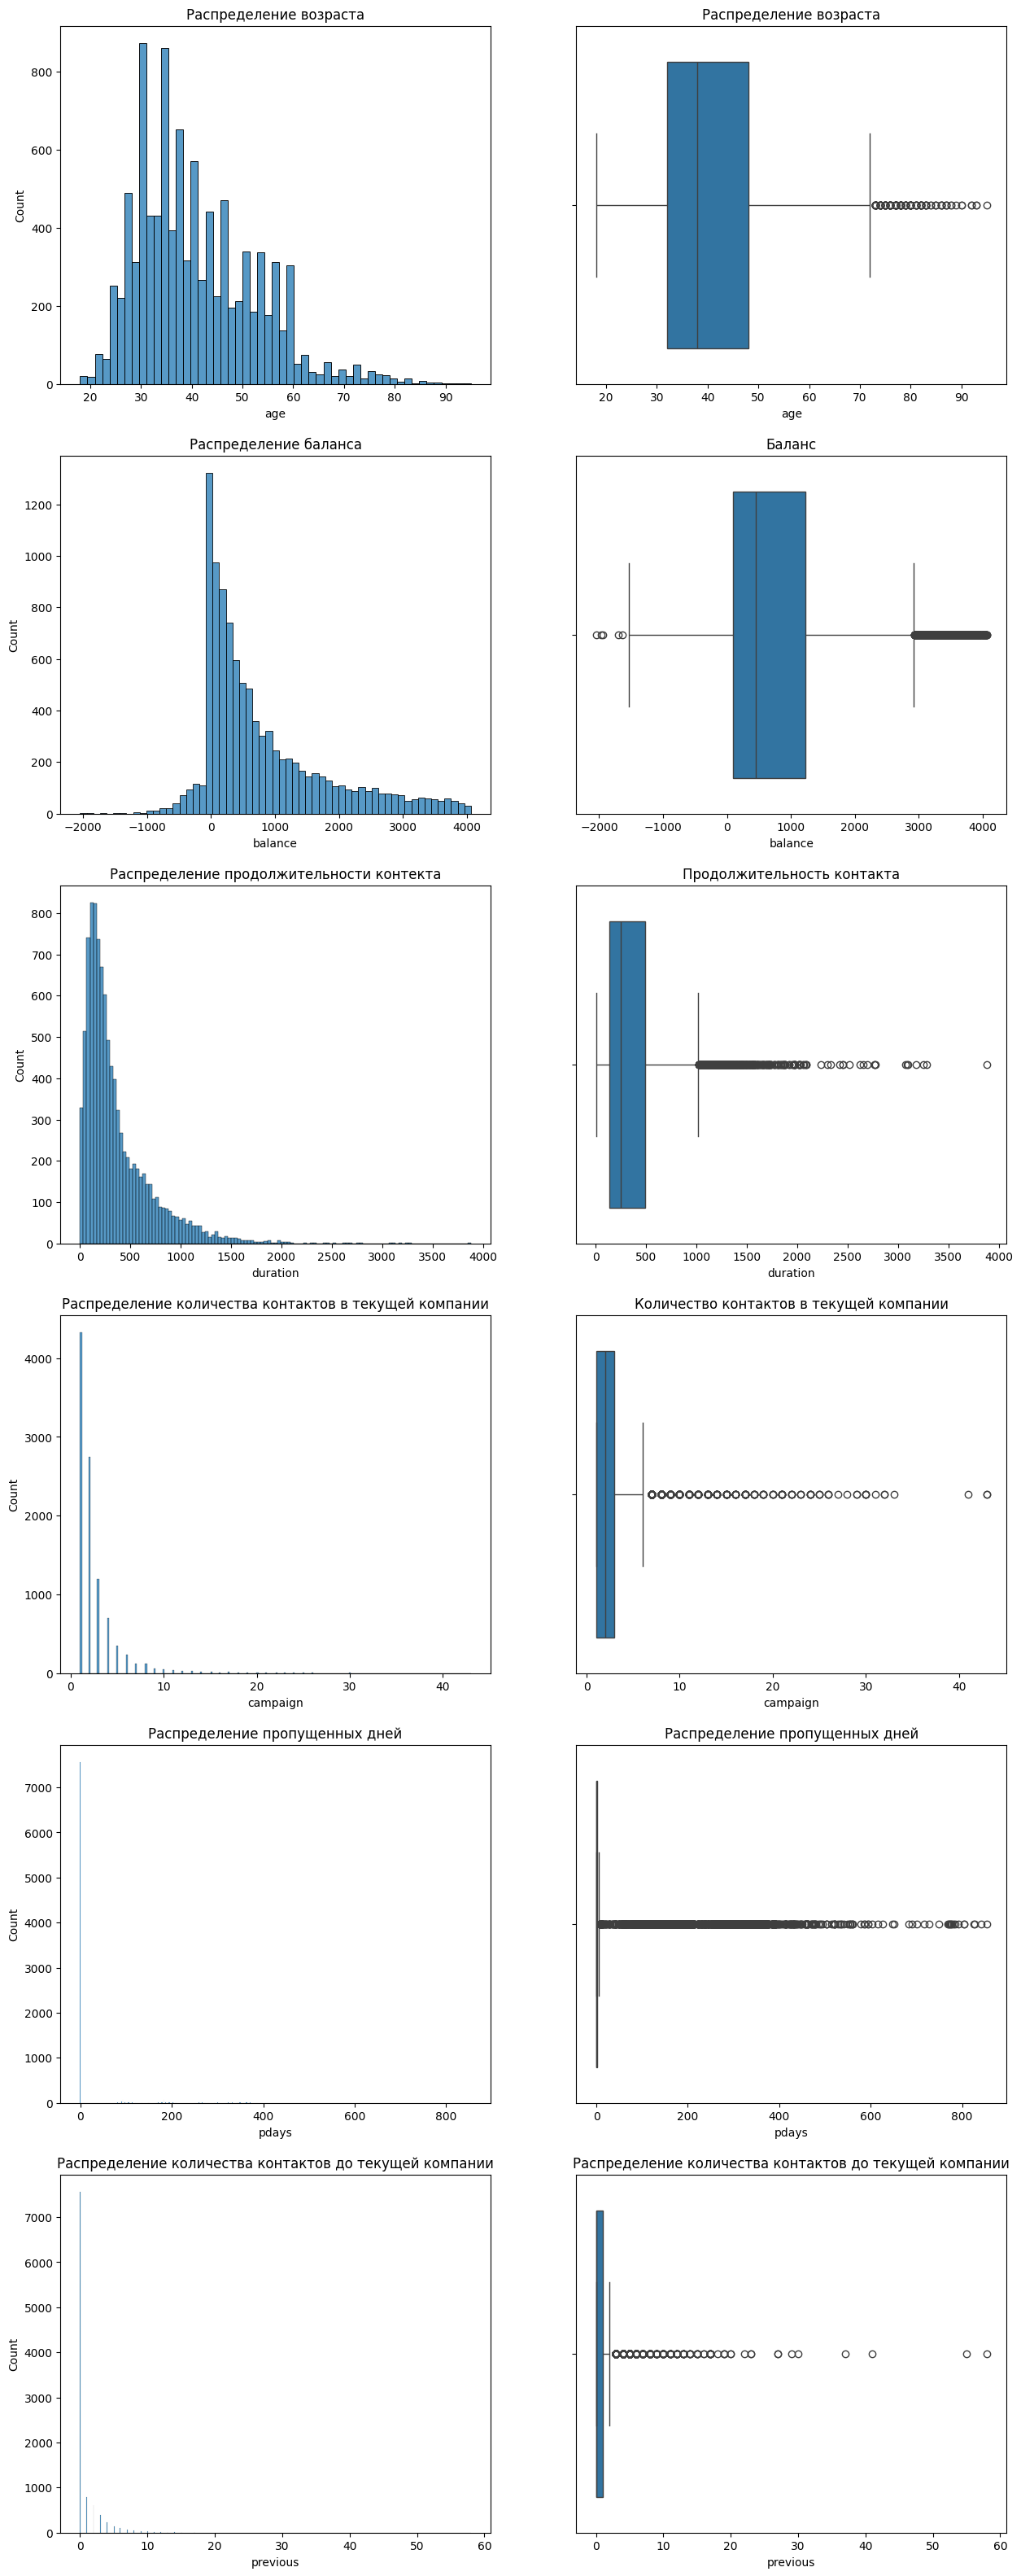

In [13]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
df_filtered.describe()
fig, axes = plt.subplots(6,2, figsize = (15,40))
sns.histplot(data = df_filtered, x = 'age', ax = axes[0][0]);
axes[0][0].set_title('Распределение возраста')
sns.boxplot( data = df_filtered, x = 'age', ax = axes[0][1])
axes[0][1].set_title('Распределение возраста')
sns.histplot(data = df_filtered, x = 'balance', ax = axes[1][0]);
axes[1][0].set_title('Распределение баланса')
sns.boxplot( data = df_filtered, x = 'balance', ax = axes[1][1])
axes[1][1].set_title('Баланс')
sns.histplot(data = df_filtered, x = 'duration', ax = axes[2][0]);
axes[2][0].set_title('Распределение продолжительности контекта')
sns.boxplot( data = df_filtered, x = 'duration', ax = axes[2][1])
axes[2][1].set_title('Продолжительность контакта')
sns.histplot(data = df_filtered, x = 'campaign', ax = axes[3][0]);
axes[3][0].set_title('Распределение количества контактов в текущей компании')
sns.boxplot( data = df_filtered, x = 'campaign', ax = axes[3][1])
axes[3][1].set_title('Количество контактов в текущей компании')
sns.histplot(data = df_filtered, x = 'pdays', ax = axes[4][0]);
axes[4][0].set_title('Распределение пропущенных дней')
sns.boxplot( data = df_filtered, x = 'pdays', ax = axes[4][1])
axes[4][1].set_title('Распределение пропущенных дней')
sns.histplot(data = df_filtered, x = 'previous', ax = axes[5][0]);
axes[5][0].set_title('Распределение количества контактов до текущей компании')
sns.boxplot( data = df_filtered, x = 'previous', ax = axes[5][1])
axes[5][1].set_title('Распределение количества контактов до текущей компании')
df_filtered.describe()

### Задания 4 и 5

In [14]:
import plotly
import plotly.express as px

In [15]:
df_filtered.describe(include=['object'])

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Text(0.5, 1.0, 'Распределение по результату прошлой компании')

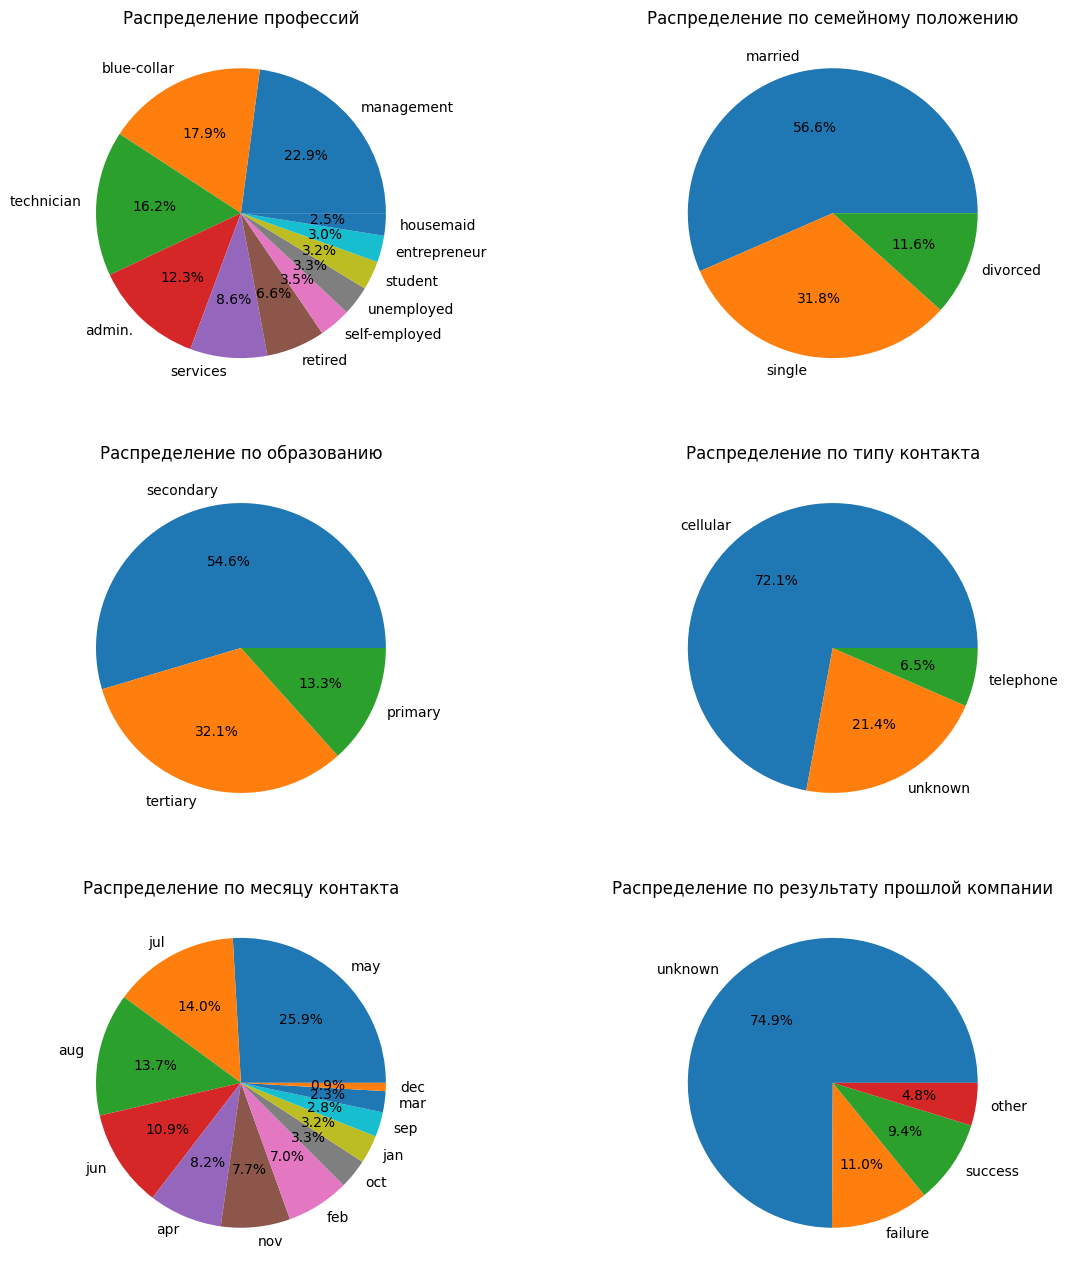

In [16]:
job_count = df_filtered['job'].value_counts()
matital_count = df_filtered['marital'].value_counts()
education_count = df_filtered['education'].value_counts()
contact_count = df_filtered['contact'].value_counts()
month_count = df_filtered['month'].value_counts()
poutcome_count = df_filtered['poutcome'].value_counts()
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize=(14,16))
axes[0][0].pie(job_count, labels = job_count.index, autopct = '%.1f%%')
axes[0][0].set_title('Распределение профессий')
axes[0][1].pie(matital_count, labels = matital_count.index, autopct = '%.1f%%')
axes[0][1].set_title('Распределение по семейному положению')
axes[1][0].pie(education_count, labels = education_count.index, autopct = '%.1f%%')
axes[1][0].set_title('Распределение по образованию')
axes[1][1].pie(contact_count, labels = contact_count.index, autopct = '%.1f%%')
axes[1][1].set_title('Распределение по типу контакта')
axes[2][0].pie(month_count, labels = month_count.index, autopct = '%.1f%%')
axes[2][0].set_title('Распределение по месяцу контакта')
axes[2][1].pie(poutcome_count, labels = poutcome_count.index, autopct = '%.1f%%')
axes[2][1].set_title('Распределение по результату прошлой компании')

In [17]:
def build_histogram(data, x, color, title):
    fig = px.histogram(
        data_frame = data,
        x = x,
        color = color,
        orientation = 'v',
        height = 350,
        width = 600,
        nbins = 25,
        title = title)
    return fig.show()
build_histogram(df_filtered, 'default', 'deposit', 'Распределение целевого показателя \n по клиентам с просроченным кредитом')
build_histogram(df_filtered, 'housing', 'deposit', 'Распределение целевого показателя \n по клиентам с кредитом на жилье')
build_histogram(df_filtered, 'loan', 'deposit', 'Распределение целевого показателя \n по клиентам с кредитом на личные нужды')
build_histogram(df_filtered, 'contact', 'deposit', 'Распределение целевого показателя по типу контакта')
build_histogram(df_filtered, 'month', 'deposit', 'Распределение целевого показателя по мясяцу контакта')
build_histogram(df_filtered, 'poutcome', 'deposit', 'Распределение целевого показателя по результату прошлой компании')

### Задание 6

In [18]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
df_filtered.groupby('poutcome')['deposit'].value_counts(normalize=True).sort_values(ascending=False)


poutcome  deposit
success   yes        0.911111
unknown   no         0.602642
other     yes        0.550936
failure   no         0.506763
          yes        0.493237
other     no         0.449064
unknown   yes        0.397358
success   no         0.088889
Name: proportion, dtype: float64

### Задание 7

In [19]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
#mask = md['deposit'] =='no'
df_filtered.groupby('month')['deposit'].value_counts(normalize=True).sort_values(ascending=False)
#df_filtered.groupby('month')['deposit'].value_counts().unstack()
#df_filtered[df_filtered['deposit']=='no']

month  deposit
dec    yes        0.903226
mar    yes        0.898734
sep    yes        0.834532
oct    yes        0.814925
may    no         0.678640
apr    yes        0.618072
jan    no         0.608150
jul    no         0.589563
nov    no         0.584615
aug    no         0.559567
jun    no         0.548913
feb    yes        0.544429
       no         0.455571
jun    yes        0.451087
aug    yes        0.440433
nov    yes        0.415385
jul    yes        0.410437
jan    yes        0.391850
apr    no         0.381928
may    yes        0.321360
oct    no         0.185075
sep    no         0.165468
mar    no         0.101266
dec    no         0.096774
Name: proportion, dtype: float64

### Задание 8

In [20]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def get_cat_age(age):
    if 0 <= age <= 30:
        return '<30'
    elif 30 <= age <= 40:
        return '30-40'
    elif 40 <= age <= 50:
        return '40-50'
    elif 50 <= age <= 60:
        return '50-60'
    return '60+'
df_filtered['age_cat'] = df_filtered['age'].apply(get_cat_age)
build_histogram(df_filtered, 'age_cat', 'deposit', 'Распределение целевого показателя по возрастным категориям')
df_filtered.groupby('age_cat')['deposit'].value_counts(normalize=True).sort_values(ascending=False)

age_cat  deposit
60+      yes        0.810916
40-50    no         0.603104
30-40    no         0.576523
50-60    no         0.574154
<30      yes        0.562032
         no         0.437968
50-60    yes        0.425846
30-40    yes        0.423477
40-50    yes        0.396896
60+      no         0.189084
Name: proportion, dtype: float64

### Задания 9 и 10

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
build_histogram(df_filtered, 'marital', 'deposit', 'Распределение целевого показателя по семейному положению')
df_filtered.groupby('marital')['deposit'].value_counts(normalize=True).sort_values(ascending=False)

marital   deposit
married   no         0.577953
single    yes        0.534080
divorced  no         0.530161
          yes        0.469839
single    no         0.465920
married   yes        0.422047
Name: proportion, dtype: float64

In [22]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
build_histogram(df_filtered, 'education', 'deposit', 'Распределение целевого показателя по уровню образования')

In [23]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
build_histogram(df_filtered, 'job', 'deposit', 'Распределение целевого показателя по профессиям')
df_filtered['job'].value_counts()

job
management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: count, dtype: int64

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


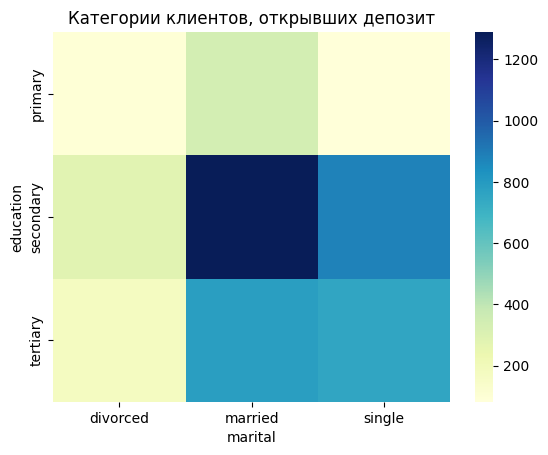

In [24]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_yes = df_filtered[df_filtered['deposit']=='yes']
pivot_yes = df_yes.pivot_table(values='deposit', index='education', columns = 'marital', aggfunc='count')
heatmap = sns.heatmap(data = pivot_yes, cmap='YlGnBu')
heatmap.set_title('Категории клиентов, открывших депозит')
pivot_yes


marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


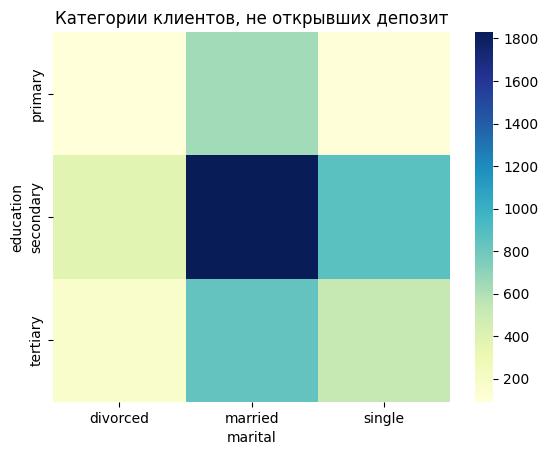

In [25]:
df_no = df_filtered[df_filtered['deposit']=='no']
pivot_no = df_no.pivot_table(values='deposit', index='education', columns = 'marital', aggfunc='count')
heatmap = sns.heatmap(data = pivot_no, cmap='YlGnBu')
heatmap.set_title('Категории клиентов, не открывших депозит')
pivot_no

## Часть 3: преобразование данных

### Задание 1

In [26]:
# преобразуйте уровни образования
label_enc = LabelEncoder()
df_filtered['education'] = label_enc.fit_transform(df_filtered['education'])
df_filtered['age_cat'] = label_enc.fit_transform(df_filtered['age_cat'])
df_filtered['education'].sum()

11995

### Задания 2 и 3

In [27]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df_filtered['deposit'] = df_filtered['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
print(f'Стандартное отклонение:{round(df_filtered['deposit'].std(),3)}')
df_filtered['default'] = df_filtered['default'].apply(lambda x: 1 if x == 'yes' else 0)
df_filtered['housing'] = df_filtered['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df_filtered['loan'] = df_filtered['loan'].apply(lambda x: 1 if x == 'yes' else 0)
mean_def = df_filtered['default'].mean()
mean_hous = df_filtered['housing'].mean()
mean_loan = df_filtered['loan'].mean()
print(f'Итог:{round(mean_def+mean_hous+mean_loan,3)}')

Стандартное отклонение:0.499
Итог:0.635


### Задание 4

In [28]:
# создайте дамми-переменные
df_filtered = pd.get_dummies(df_filtered, columns = ['job'])
df_filtered = pd.get_dummies(df_filtered, columns = ['marital'])
df_filtered = pd.get_dummies(df_filtered, columns = ['contact'])
df_filtered = pd.get_dummies(df_filtered, columns = ['month'])
df_filtered = pd.get_dummies(df_filtered, columns = ['poutcome'])

In [29]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_cat            10105 non-null  int32  
 13  job_admin.         10105 non-null  bool   
 14  job_blue-collar    10105 non-null  bool   
 15  job_entrepreneur   10105 non-null  bool   
 16  job_housemaid      10105 no

### Задания 5 и 6

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,-0.166456,-0.003893,0.081252,-0.119248,-0.006972,-0.000045,-0.018633,0.025750,0.011679,...,0.028733,0.005835,-0.102180,0.037391,0.032888,0.009335,0.007135,-0.026381,0.032457,-0.013986
education,-0.166456,1.000000,-0.015098,0.050499,-0.100144,-0.056090,0.007846,0.001485,-0.006279,0.054179,...,-0.034826,0.054584,-0.108045,0.028172,0.028018,0.031689,0.018547,0.014332,0.069692,-0.067219
default,-0.003893,-0.015098,1.000000,-0.147095,0.009551,0.074786,0.019304,-0.004294,0.019141,-0.051644,...,0.019626,-0.020028,-0.001761,0.000544,-0.023931,-0.016977,-0.025450,-0.017923,-0.041510,0.055032
balance,0.081252,0.050499,-0.147095,1.000000,-0.093566,-0.121213,-0.017385,0.047316,-0.042144,0.092944,...,0.039102,0.042921,-0.099615,0.069077,0.061742,0.057213,0.036421,0.029792,0.091857,-0.102586
housing,-0.119248,-0.100144,0.009551,-0.093566,1.000000,0.072252,-0.018544,-0.004923,-0.004771,0.002547,...,-0.073133,-0.075948,0.432605,-0.000219,-0.092026,-0.086893,0.085167,0.009830,-0.134477,0.024082
loan,-0.006972,-0.056090,0.074786,-0.121213,0.072252,1.000000,0.020769,-0.036197,0.019465,-0.051194,...,-0.014897,-0.041105,0.002778,0.017720,-0.032357,-0.046196,0.007458,-0.019289,-0.082098,0.059235
day,-0.000045,0.007846,0.019304,-0.017385,-0.018544,0.020769,1.000000,-0.043949,0.112210,-0.089067,...,-0.180363,-0.046924,-0.018475,0.077322,0.073838,-0.067546,-0.071108,-0.010164,-0.046855,0.087732
duration,-0.018633,0.001485,-0.004294,0.047316,-0.004923,-0.036197,-0.043949,1.000000,-0.056886,0.009770,...,-0.023034,-0.021341,0.006136,-0.027478,0.004775,0.015527,-0.025959,0.002677,0.039908,-0.009401
campaign,0.025750,-0.006279,0.019141,-0.042144,-0.004771,0.019465,0.112210,-0.056886,1.000000,-0.127716,...,0.035564,-0.035865,-0.031866,-0.086668,-0.099462,-0.059782,-0.079041,-0.009832,-0.109664,0.135473
pdays,0.011679,0.054179,-0.051644,0.092944,0.002547,-0.051194,-0.089067,0.009770,-0.127716,1.000000,...,-0.092701,0.039730,-0.026063,0.042674,0.104941,0.130016,0.629867,0.388596,0.507395,-0.985791


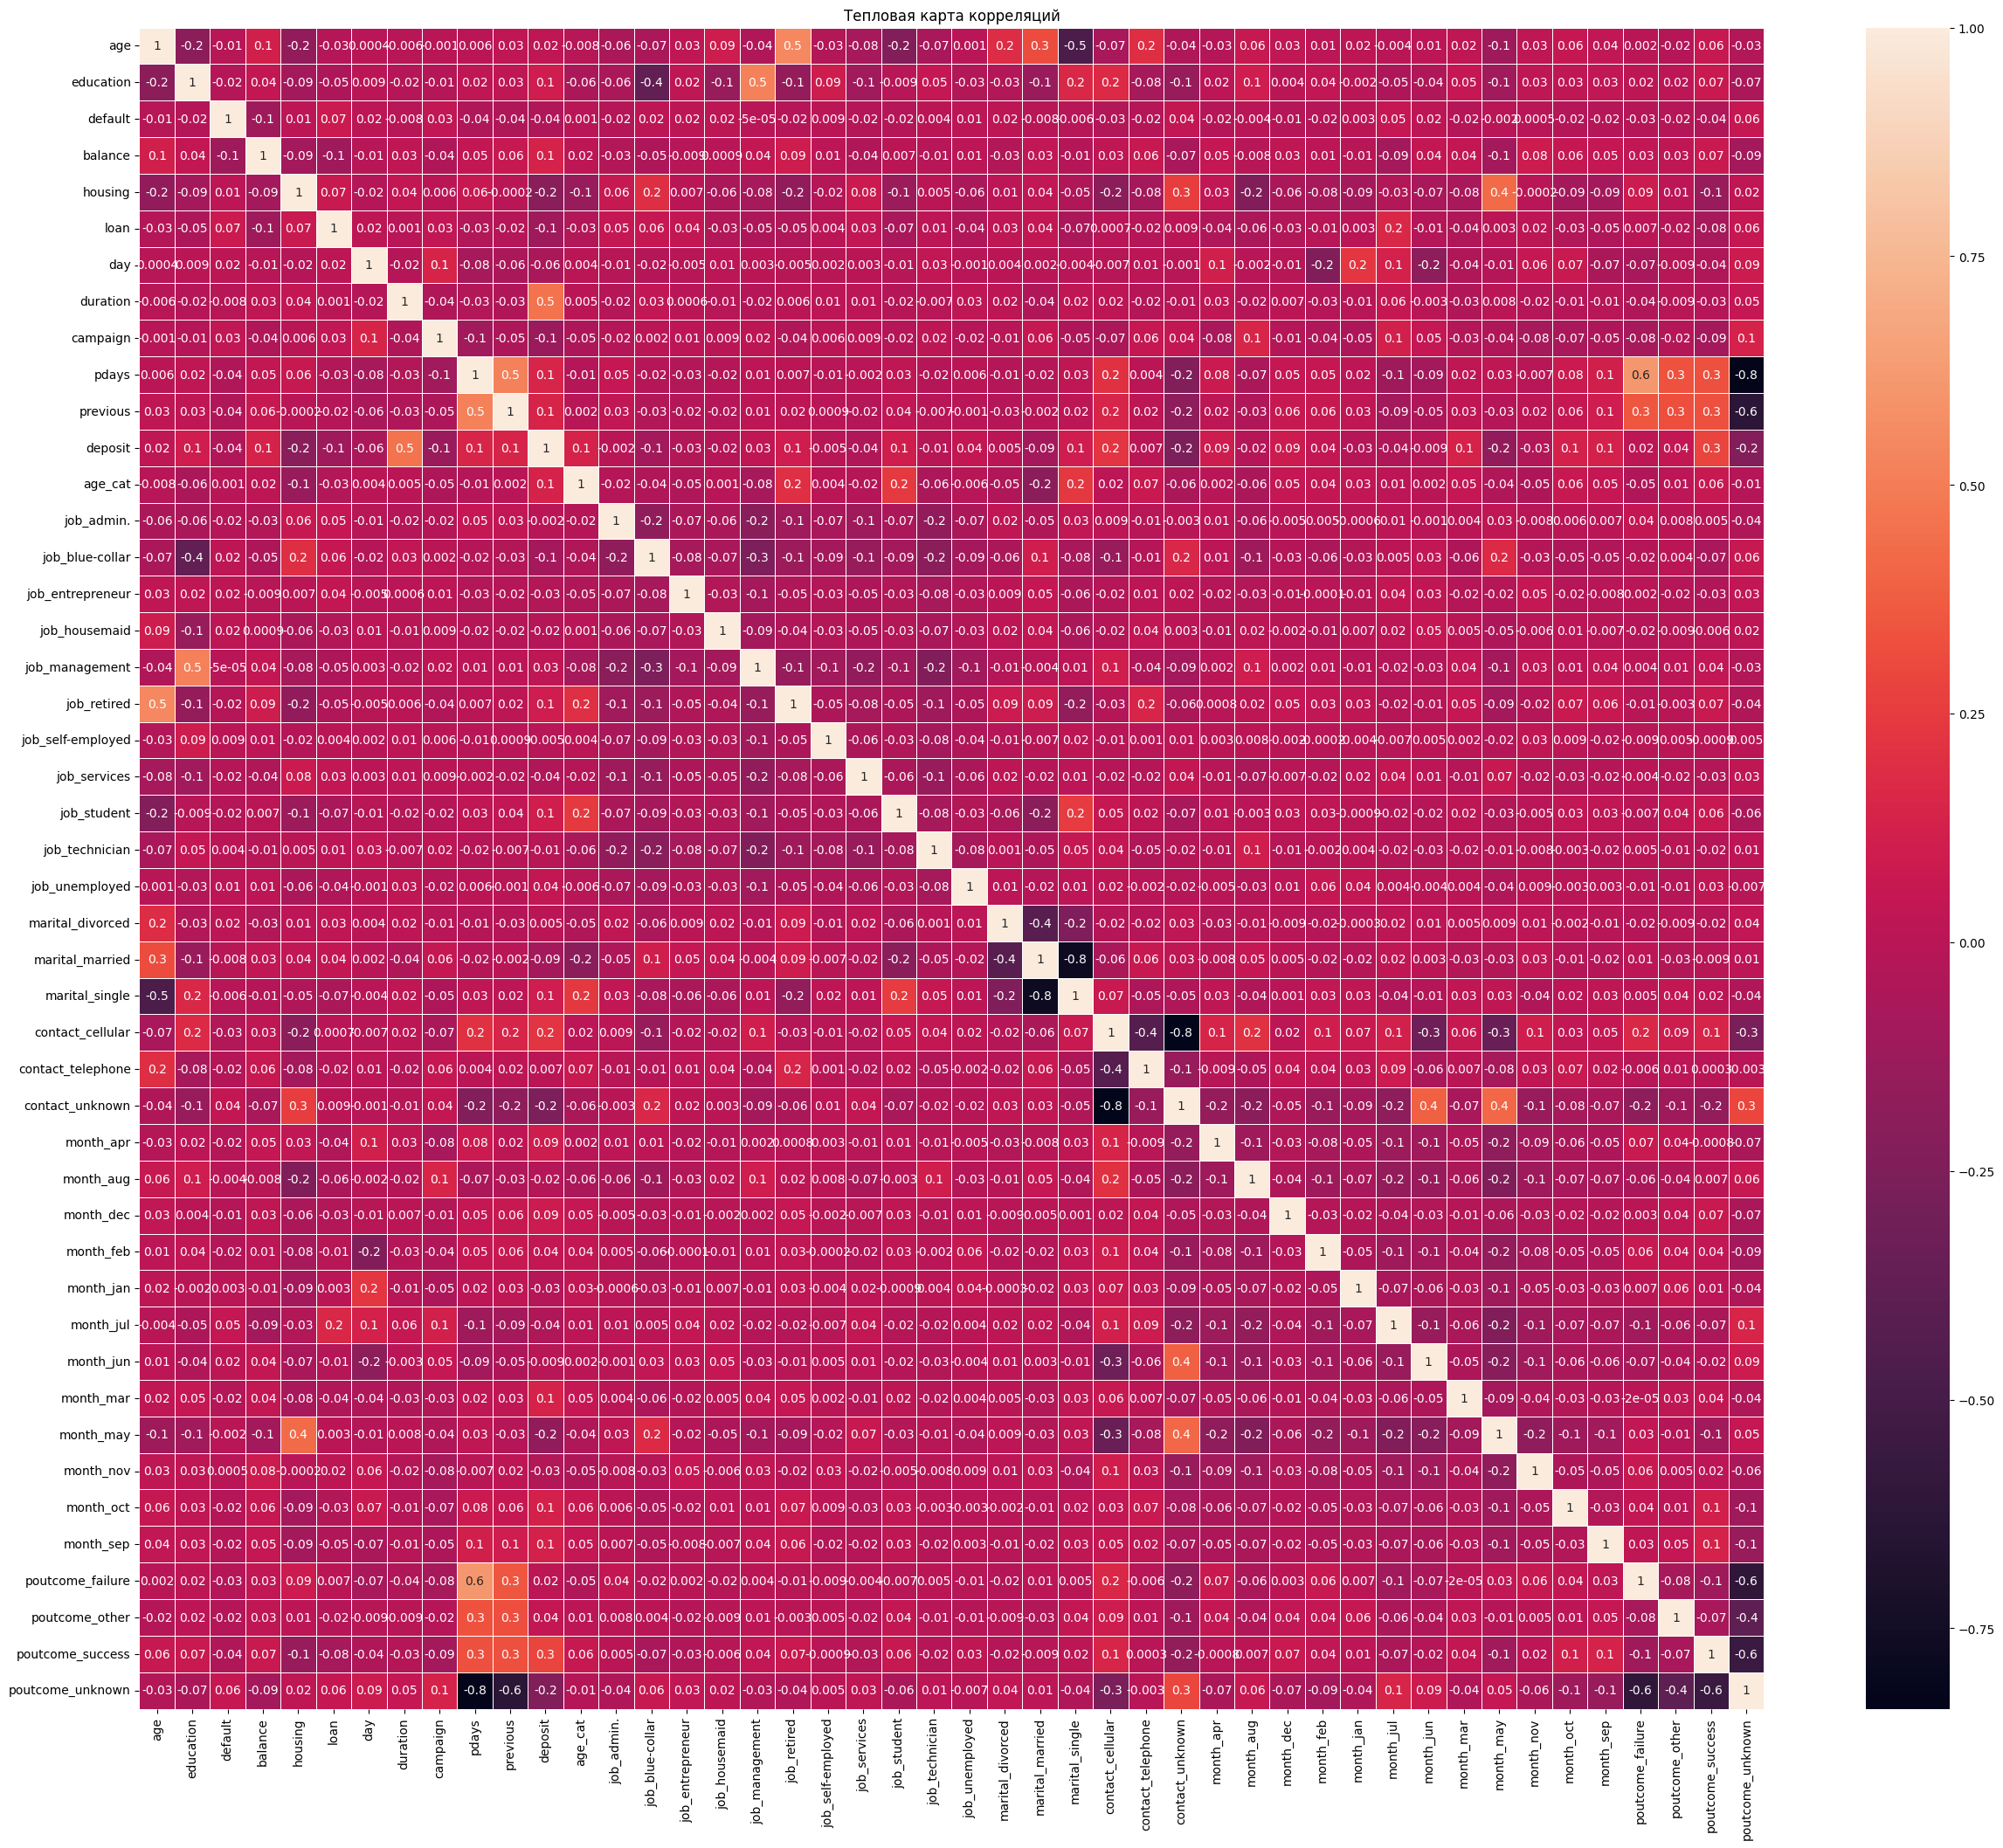

In [30]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
fig, ax = plt.subplots(figsize=(30,25))
sns.heatmap(df_filtered.corr(), linewidth=.5, annot=True, fmt='.1g', ax=ax)
ax.set_title('Тепловая карта корреляций')
df_filtered.corr(method='spearman')

### Задания 7 и 8

In [31]:
X = df_filtered.drop(['deposit'], axis=1)
y = df_filtered['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [32]:
# рассчитайте необходимые показатели
print(f'Размер тестовой выборки: {X_test.shape[0]}')
print(f'Среднее значение целевой переменной на тестовой выборке: {round(y_test.values.mean(),2)}')

Размер тестовой выборки: 3335
Среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [33]:
# отбираем признаки
selector = SelectKBest(
    score_func = f_classif,
    k = 15
)
selector.fit(X_train, y_train)

# оставляем только полученные 15 признаков
best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_test = X_test[best_features]
print('Признаки, которые вошли в список отобранных:\n', best_features)

Признаки, которые вошли в список отобранных:
 ['balance' 'housing' 'duration' 'campaign' 'pdays' 'previous' 'age_cat'
 'contact_cellular' 'contact_unknown' 'month_mar' 'month_may' 'month_oct'
 'month_sep' 'poutcome_success' 'poutcome_unknown']


### Задание 10

In [34]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
X_train_sc = mm_scaler.fit_transform(X_train)
X_test_sc = mm_scaler.transform(X_test)
print(f'Cреднее арифметическое для первого предиктора из тестовой выборки: {round(X_test_sc[:, 0].mean(),2)}')

Cреднее арифметическое для первого предиктора из тестовой выборки: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [35]:
# обучите логистическую регрессию и рассчитайте метрики качества
lr_model = linear_model.LogisticRegression(solver='sag', random_state=42)
lr_model.fit(X_train_sc, y_train)
y_pred = lr_model.predict(X_test_sc)
print(f'accuracy на тестовой выборке: {round(metrics.accuracy_score(y_test, y_pred),2)}')

accuracy на тестовой выборке: 0.81


### Задания 2,3,4

In [36]:
# обучите решающие деревья, настройте максимальную глубину
dtf_model = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=6, random_state=42)
dtf_model.fit(X_train_sc, y_train)
y_train_pred = dtf_model.predict(X_train_sc)
y_pred_dtf = dtf_model.predict(X_test_sc)
print(f'accuracy на тестовой выборке: {round(metrics.accuracy_score(y_train, y_train_pred),2)}')
print(f'accuracy на тестовой выборке: {round(metrics.accuracy_score(y_test, y_pred_dtf),2)}')
#print(f'Глубина дерева: {dtf_model.get_depth()}')

accuracy на тестовой выборке: 0.82
accuracy на тестовой выборке: 0.81


### Задание 5

In [37]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth':[3,5,7]
    }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=10,
    n_jobs=-1
)
grid_search.fit(X_train_sc, y_train)
print(f'Наилучшее значение параметров: {grid_search.best_params_}')
y_pred_gs = grid_search.predict(X_test_sc)
print(f'F1: {metrics.f1_score(y_test, y_pred_gs)}')

Наилучшее значение параметров: {'max_depth': 7, 'min_samples_split': 7}
F1: 0.7998725302740599


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [38]:
# обучите на ваших данных случайный лес
rf_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
rf_model.fit(X_train_sc, y_train)
y_pred_rf = rf_model.predict(X_test_sc)
print(f'Значение метрики accurary на тестовой выборке: {round(metrics.accuracy_score(y_test, y_pred_rf),2)}')
print(f'Значение метрики recall на тестовой выборке: {round(metrics.recall_score(y_test, y_pred_rf),2)}')

Значение метрики accurary на тестовой выборке: 0.83
Значение метрики recall на тестовой выборке: 0.83


### Задания 2 и 3

In [39]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
gb_model = GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb_model.fit(X_train_sc, y_train)
y_pred_gb = gb_model.predict(X_test_sc)
print(f'Значение f1 на тестововй выборке: {round(metrics.f1_score(y_test, y_pred_gb),2)}')

Значение f1 на тестововй выборке: 0.82


### Задание 4

In [40]:
# объедините уже известные вам алгоритмы с помощью стекинга
from sklearn.ensemble import StackingClassifier
estimators = [('dt', tree.DecisionTreeClassifier(
    criterion = 'entropy', 
    max_depth=6, random_state=42)
     ),
    ('lr', linear_model.LogisticRegression(
        solver='sag', 
        random_state=42)
     ),
    ('gb', GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42)
     )
              ]
sr_model = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
sr_model.fit(X_train_sc, y_train)
y_pred_sr = sr_model.predict(X_test_sc)
print(f'Значение ptecision на тестововй выборке: {round(metrics.precision_score(y_test, y_pred_sr),2)}')

Значение ptecision на тестововй выборке: 0.81


### Задание 5

In [41]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
from sklearn.feature_selection import RFE
estimator = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

### Задания 6,7,8

In [42]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
random_state = 42
def optuna_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    model.fit(X_train_sc, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_sc))
    return score
%time
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study.optimize(optuna_rf, n_trials=20)
print(f'Наилучшие значение гиперпараметров: {study.best_params}')
model = ensemble.RandomForestClassifier(
    **study.best_params, 
    random_state=random_state
)
model.fit(X_train_sc, y_train)
y_pred_op = model.predict(X_test_sc)
print(f'Значение f1 на тестововй выборке: {round(metrics.f1_score(y_test, y_pred_op),2)}')
print(f'Значение accuracy на тестововй выборке: {round(metrics.accuracy_score(y_test, y_pred_op),2)}')

[I 2024-11-03 15:37:20,819] A new study created in memory with name: RandomForestClassifier


CPU times: total: 0 ns
Wall time: 0 ns


[I 2024-11-03 15:37:23,562] Trial 0 finished with value: 0.8653786226238704 and parameters: {'n_estimators': 161, 'max_depth': 20, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8653786226238704.
[I 2024-11-03 15:37:25,985] Trial 1 finished with value: 0.866822794691647 and parameters: {'n_estimators': 186, 'max_depth': 14, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.866822794691647.
[I 2024-11-03 15:37:27,005] Trial 2 finished with value: 0.8458510470792001 and parameters: {'n_estimators': 118, 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.866822794691647.
[I 2024-11-03 15:37:28,688] Trial 3 finished with value: 0.8510104966316778 and parameters: {'n_estimators': 183, 'max_depth': 11, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.866822794691647.
[I 2024-11-03 15:37:30,483] Trial 4 finished with value: 0.8661048689138577 and parameters: {'n_estimators': 184, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8668227

Наилучшие значение гиперпараметров: {'n_estimators': 148, 'max_depth': 29, 'min_samples_leaf': 2}
Значение f1 на тестововй выборке: 0.82
Значение accuracy на тестововй выборке: 0.83
